In [1]:
# Load various imports
import numpy as np
import pandas as pd
import os
import librosa
import ast

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sn

from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

import joblib

Using TensorFlow backend.


### Função para extrair MFCCs de um ficheiro de áudio:

In [2]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13, hop_length=512)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

Extrai 13 listas de 173 valores: (ou 173 colunas, cada uma com 13 valores)<br>data_exp.shape = (13, 173), ou seja 13 coeficientes para cada 1 dos 173 bins<br>axis=0 significa ao longo da coluna

In [3]:
filename = 'US8KS/air_conditioner.wav'
data_exp=extract_features(filename)
data_exp[0] #coeficiente 1 de cada um dos bins
# data_exp.shape

-106.46682236817625

np.mean faz uma média de um coefficiente presente em todos os bins<br>ou seja, percorre todo o eixo do x (x entre 1 e 173) e faz uma média de todos os valores do coeficiente y (y entre 1 e 13)

In [4]:
filename = 'US8KS/air_conditioner.wav'
data_exp=extract_features(filename)
data_exp[0]
mean=np.mean(data_exp.T, axis=0)
mean

-6.521904296223367

In [5]:
# Read the metadata
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [6]:
# # Set the path to the full UrbanSound8K dataset 
# fulldatasetpath = '/Users/pedro/OneDrive - Universidade do Porto/Tese/UrbanSound8K/audio/'

# # Read the metadata
# metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

# features = []

# # Iterate through each sound file and extract the features 
# for index, row in metadata.iterrows():
    
#     file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
#     class_label = row["class_name"]
#     data = extract_features(file_name)
    
#     features.append([data, class_label])

# # Convert into a Panda dataframe 
# featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

# print('Finished feature extraction from ', len(featuresdf), ' files')

In [7]:
#featuresdf

In [8]:
# def transform_to_list(row):
#     return row.feature.tolist()
# featuresdf["feature"] = featuresdf.apply(transform_to_list, axis=1)

In [9]:
# featuresdf.to_csv("13MFCCs.csv", sep="|", index=False)

In [10]:
new_featuresdf = pd.read_csv("13MFCCs.csv", sep="|")
new_featuresdf

,feature,class_label
0,"[-215.79300197978586, 71.6661218577675, -131.8...",dog_bark
1,"[-424.68685717404645, 110.56227614968253, -54....",children_playing
2,"[-459.56466281715973, 122.80034862683691, -47....",children_playing
3,"[-414.55377053561494, 102.89690543200295, -36....",children_playing
4,"[-447.39699928170836, 115.09538477641466, -53....",children_playing
...,...,...
8727,"[-399.2257209098363, 136.81901320524457, -51.9...",car_horn
8728,"[-346.7273127859397, 87.4884743538864, -46.265...",car_horn
8729,"[-304.6131609118385, 112.61991286445974, -47.1...",car_horn
8730,"[-344.7142096344138, 126.7581432632123, -56.17...",car_horn


In [11]:
def convert_to_list(row):
    return ast.literal_eval(row.feature)
new_featuresdf['feature'] = new_featuresdf.apply(convert_to_list, axis=1)

In [12]:
new_featuresdf

,feature,class_label
0,"[-215.79300197978586, 71.6661218577675, -131.8...",dog_bark
1,"[-424.68685717404645, 110.56227614968253, -54....",children_playing
2,"[-459.56466281715973, 122.80034862683691, -47....",children_playing
3,"[-414.55377053561494, 102.89690543200295, -36....",children_playing
4,"[-447.39699928170836, 115.09538477641466, -53....",children_playing
...,...,...
8727,"[-399.2257209098363, 136.81901320524457, -51.9...",car_horn
8728,"[-346.7273127859397, 87.4884743538864, -46.265...",car_horn
8729,"[-304.6131609118385, 112.61991286445974, -47.1...",car_horn
8730,"[-344.7142096344138, 126.7581432632123, -56.17...",car_horn


In [13]:
new_featuresdf.feature[0]

[-215.79300197978586,
 71.6661218577675,
 -131.8137710605355,
 -52.09133106039041,
 -22.115966541692504,
 -21.764182004937346,
 -11.18374714512825,
 18.91268019506631,
 6.726638568856883,
 14.55689415517604,
 -11.782045895784535,
 2.301036870326384,
 -17.25130422975169]

In [14]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(new_featuresdf.feature.tolist())
y = np.array(new_featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) #Transforms class labels into binary vectores with 1 on the respective class

In [15]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [16]:
print(x_train.shape)
x_train

(6985, 13)


array([[ -88.92953108,  117.30896887,  -98.37564672, ...,   -2.74858223,
           7.96005893,   -9.57434491],
       [-162.97491759,  135.34387275,  -26.99131247, ...,  -18.72633186,
           1.00752715,  -18.56717094],
       [-262.99781128,  178.10604279, -112.84569232, ...,    0.98362871,
          12.22776064,   29.68025573],
       ...,
       [-290.99601244,  233.35096427,   -4.672565  , ...,    3.19426007,
           3.89901707,    0.97521904],
       [-201.69655821,   93.59072473,  -80.86042064, ...,   -8.96189396,
          15.57949196,   -6.66443157],
       [-271.51473186,  135.73034422,   -9.02778043, ...,  -12.66044985,
           8.8065049 ,  -13.70408343]])

In [17]:
print(x_test.shape)
x_test

(1747, 13)


array([[ -82.12358939,  139.50591598,  -42.43086489, ...,   -7.36882138,
          14.25433903,   -8.67870015],
       [ -15.74400541,  124.11995993,  -29.42888126, ...,  -17.38768904,
           0.73712233,  -16.28922845],
       [-123.39365145,   15.18194631,  -50.09332904, ...,  -11.19345959,
           9.59290493,   -8.26916969],
       ...,
       [-405.09167417,  155.38215147,   30.87562165, ...,    2.32812473,
          -4.03490686,    7.69889089],
       [-169.86908191,   92.62239816,   -4.04844988, ...,   -8.61203878,
          -1.53035437,  -18.78486133],
       [-196.62097393,  152.14464786,  -57.457441  , ...,   -0.86217024,
          15.78636943,   -6.81015979]])

In [18]:
print(y_train.shape)
y_train

(6985, 10)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [19]:
print(y_test.shape)
y_test

(1747, 10)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# Logistic Regression

Dá para fazer logistic regression com CV já incorporada, pesquisar no sklearn

In [20]:
model = LogisticRegression(multi_class='ovr',max_iter=200)

O seguinte passo basicamente retorna um vetor com os índices das labels de cada sample <br>
np.argmax returnes the indices of the highest values

In [21]:
y_train_one_column = []
for one_hot_array in y_train:
    y_train_one_column.append(str(np.argmax(one_hot_array)))
y_train_one_column = np.array(y_train_one_column)
y_test_one_column = []
for one_hot_array in y_test:
    y_test_one_column.append(str(np.argmax(one_hot_array)))
y_test_one_column = np.array(y_test_one_column)

In [22]:
print(y_train_one_column.shape)
y_train_one_column

(6985,)


array(['8', '9', '8', ..., '0', '8', '8'], dtype='<U1')

In [23]:
print(y_test_one_column.shape)
y_test_one_column

(1747,)


array(['8', '9', '4', ..., '5', '9', '8'], dtype='<U1')

In [24]:
model.fit(x_train, y_train_one_column)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
model.score(x_test, y_test_one_column)

0.4882655981682885

In [26]:
y_predicted = model.predict(x_test)

Text(68.09375, 0.5, 'Truth')

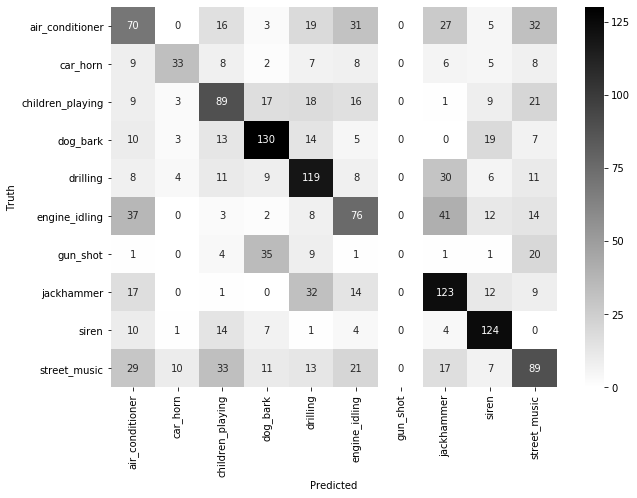

In [27]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']

cm = confusion_matrix(y_test_one_column, y_predicted)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='g', cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

Pôr normalize='true' é basicamente dizer que se quer obter a precisão.

Text(68.09375, 0.5, 'Truth')

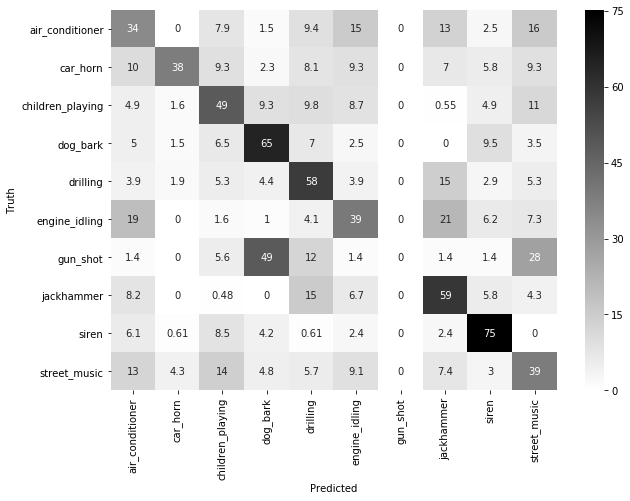

In [28]:
cm = confusion_matrix(y_test_one_column, y_predicted, normalize='true')*100

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Random Forest

* number of decision trees used (n_estimators): 20
* criterion (gini  or entropy): gini
* seed used by the random state generator for randomizing the dataset (random_state): 42

In [29]:
# training a Random Forest classifier
model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(x_train, y_train_one_column)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [30]:
model.score(x_test, y_test_one_column)

0.8483113909559244

In [31]:
y_predicted = model.predict(x_test)

Text(68.09375, 0.5, 'Truth')

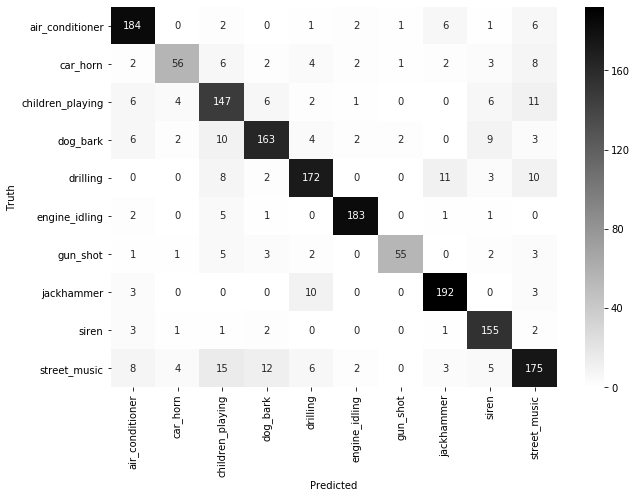

In [32]:
cm = confusion_matrix(y_test_one_column, y_predicted)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='g', cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(68.09375, 0.5, 'Truth')

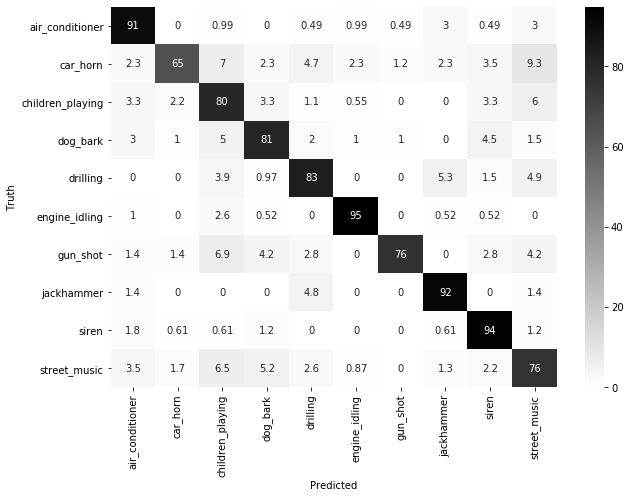

In [33]:
cm = confusion_matrix(y_test_one_column, y_predicted, normalize='true')*100

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Feed-forward Neural Network

In [34]:
num_labels = y_train.shape[1]

N=1

model = Sequential()

model.add(Dense(1024, input_shape=(13,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))

for i in range(N-1):
    model.add(Dense(1024))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x_train, y_train, batch_size=32, epochs=1000)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1000





6985/6985 [==============================] - 1s 143us/step - loss: 1.8422 - acc: 0.3708
Epoch 2/1000
6985/6985 [==============================] - 0s 65us/step - loss: 1.4736 - acc: 0.4922
Epoch 3/1000
6985/6985 [==============================] - 1s 83us/step - loss: 1.3454 - acc: 0.5361
Epoch 4/1000
6985/6985 [==============================] - 0s 64us/step - loss: 1.2545 - acc: 0.5642
Epoch 5/1000
6985/6985 [==============================] - 0s 66us/step - loss: 1.2010 - acc: 0.5828
Epoch 6/1000
6985/6985 [==============================] - 0s 64us/step - loss: 1.1409 - acc: 0.6059
Epoch 7/1000
6985/6985 [==============================] - 0s 69us/step - loss: 1.0910 - acc: 0.6210
Epoch 8/1000
6985/6985 [==============================] - 0s 65us/step - los

KeyboardInterrupt: 

In [ ]:
y_predicted = model.predict(x_test)

In [ ]:
new_y_predicted=list()
for i in y_predicted:
    maximum = max(i)
    new_list = [int(element==maximum) for element in i]
    new_y_predicted.append(new_list)
y_predicted_one_column = list()
for one_hot_array in new_y_predicted:
    y_predicted_one_column.append(str(np.argmax(one_hot_array)))
y_predicted_one_column = np.array(y_predicted_one_column)

In [ ]:
cm = confusion_matrix(y_test_one_column, y_predicted_one_column)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d',cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
cm = confusion_matrix(y_test_one_column, y_predicted_one_column, normalize='true')*100

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# k Nearest Neighbors

In [35]:
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 1).fit(x_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(x_test, y_test) 
print (accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(x_test)
y_predicted_one_column = list()
for one_hot_array in knn_predictions:
    y_predicted_one_column.append(str(np.argmax(one_hot_array)))
y_predicted_one_column = np.array(y_predicted_one_column)
cm = confusion_matrix(y_test_one_column, y_predicted_one_column)

0.8654836863194046


Text(68.09375, 0.5, 'Truth')

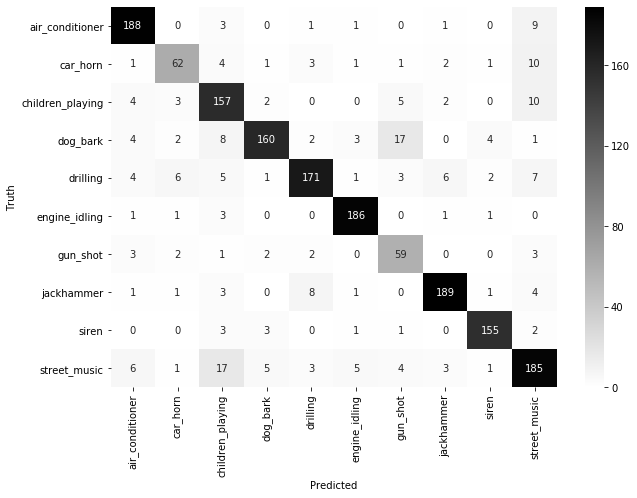

In [36]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d',cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(68.09375, 0.5, 'Truth')

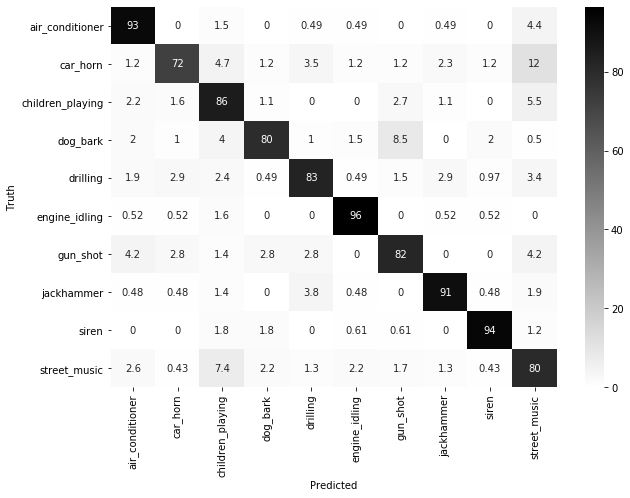

In [37]:
cm = confusion_matrix(y_test_one_column, y_predicted_one_column, normalize='true')*100

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
print(metrics.classification_report(y_test_one_column, y_predicted_one_column, digits=3))

              precision    recall  f1-score   support

           0      0.887     0.926     0.906       203
           1      0.795     0.721     0.756        86
           2      0.770     0.858     0.811       183
           3      0.920     0.796     0.853       201
           4      0.900     0.830     0.864       206
           5      0.935     0.964     0.949       193
           6      0.656     0.819     0.728        72
           7      0.926     0.909     0.917       208
           8      0.939     0.939     0.939       165
           9      0.801     0.804     0.803       230

    accuracy                          0.865      1747
   macro avg      0.853     0.857     0.853      1747
weighted avg      0.869     0.865     0.866      1747



# Support Vector Machine

In [39]:
# training a linear SVM classifier 
svm_model_linear = SVC(C = 1).fit(x_train, y_train_one_column) 
svm_predictions = svm_model_linear.predict(x_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(x_test, y_test_one_column) 
print (accuracy) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test_one_column, svm_predictions)

0.5632512879221523


Text(68.09375, 0.5, 'Truth')

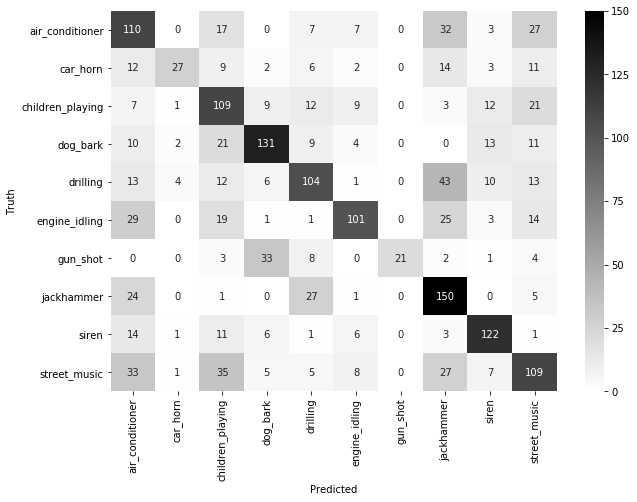

In [40]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d',cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(68.09375, 0.5, 'Truth')

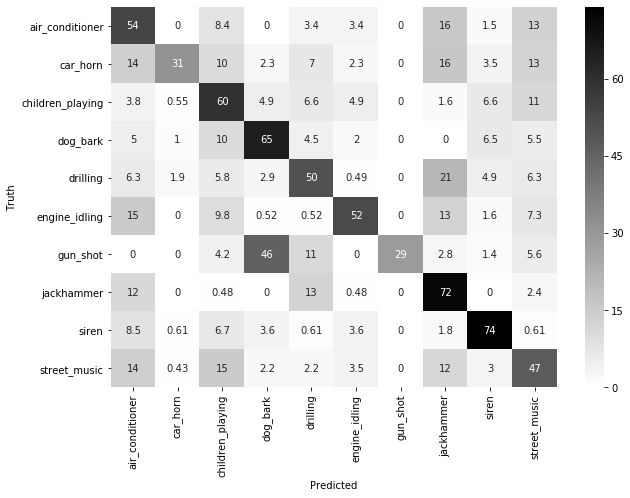

In [41]:
cm = confusion_matrix(y_test_one_column, svm_predictions, normalize='true')*100

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Guardar modelos treinados

In [42]:
joblib.dump(knn, 'knnmodel.pkl')

['knnmodel.pkl']

In [43]:
loadedknn=joblib.load('knnmodel.pkl')

In [44]:
loadedknnpredictions=loadedknn.predict(x_test)

In [45]:
knn_predictions

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [46]:
loadedknnpredictions-knn_predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
np.max(loadedknnpredictions-knn_predictions)

0.0